# Summative Activity Main Notebook

> Team kotl-mining

- LDA
- Sentiment Analysis (For truth labels)
- Naive Bayes Model
- Rule-based Model

## Setup
Import libraries and download common words using `nltk` for pre-processing

In [123]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Isang beses lang iru-run :D
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('../data/tweets.csv')
texts = df['Tweet'].dropna().tolist()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yukiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yukiro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Latent-Dirichlet Allocation
Perform pre-processing and extract top topics.

In [124]:
def preprocess(text, lemmatizer, stop_words):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


base_stops = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

processed_texts = [preprocess(t, lemmatizer, base_stops) for t in texts]

vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=1500, ngram_range=(1, 3))
dt_matrix = vectorizer.fit_transform(processed_texts)

n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=100,
                                learning_method='online',
                                random_state=42,
                                doc_topic_prior=0.1,
                                topic_word_prior=0.01
                                )
lda.fit(dt_matrix)


def display_topics(model, feature_names, no_top_words=3):
    for idx, topic in enumerate(model.components_):

        sorted_indices = topic.argsort()[:-no_top_words * 2 - 1:-1]

        unique_terms = []
        for i in sorted_indices:
            term = feature_names[i]
            if term not in unique_terms:
                unique_terms.append(term)

        print(f"Topic {idx + 1}: {' '.join(unique_terms)}")


tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 1)


Topic 1: climate change
Topic 2: climate change
Topic 3: carbon climate


## Evaluate Results
Evaluate results of LDA.

### Scale:
- **Perplexity**: Lower is better
  - Less than 200: Excellent
  - 200-500: Good
  - Greater than 500: Needs improvement

- **Topic Distinctiveness**: Target > 0.7
- **Topic Coherence**: PMI > 1.0 is good
- **Topic Diversity**: Closer to 1 is better


=== Model Performance Metrics ===
Perplexity: 1161.34
Topic Distinctiveness: 0.4000
Topic Coherence (PMI): -0.3133
Topic Diversity: 0.7182


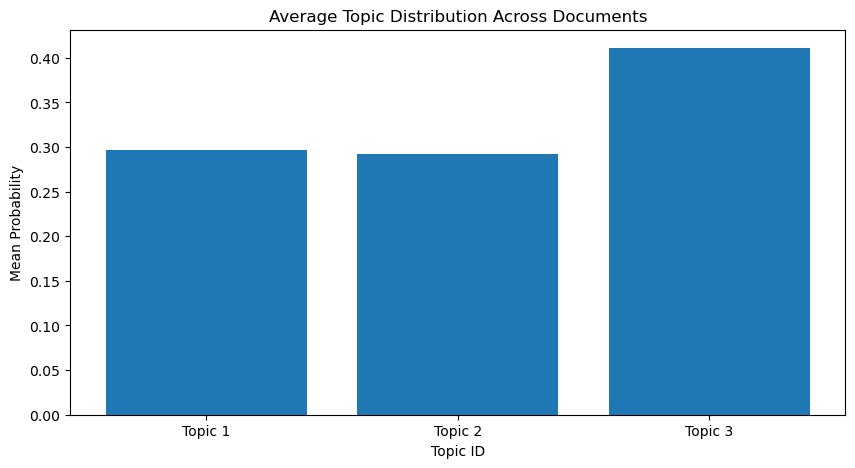

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances


# Performance Evaluation Functions
def calculate_topic_distinctiveness(components, feature_names, top_n=5):
    """Measure how distinct topics are from each other (0-1 scale)"""
    top_words_per_topic = []
    for topic in components:
        top_words_idx = topic.argsort()[-top_n:][::-1]
        top_words_per_topic.append(set(feature_names[top_words_idx]))

    distinctiveness_scores = []
    for i, topic_words in enumerate(top_words_per_topic):
        other_topics = [set(t) for j, t in enumerate(top_words_per_topic) if j != i]
        overlap_scores = [len(topic_words & other) for other in other_topics]
        distinctiveness_scores.append(1 - np.mean(overlap_scores) / top_n)

    return np.mean(distinctiveness_scores)


def calculate_topic_coherence(dt_matrix, components):
    coherence_scores = []
    for topic in components:
        top_words_idx = topic.argsort()[-5:][::-1]
        word_pairs = [(i, j) for i in top_words_idx for j in top_words_idx if i < j]

        if not word_pairs:
            continue

        # Convert sparse matrix to dense for faster calculations
        dense_matrix = (dt_matrix > 0).astype(int).toarray()
        pmi_scores = []
        for i, j in word_pairs:
            # Joint probability
            p_ij = np.mean(dense_matrix[:, i] * dense_matrix[:, j])
            # Individual probabilities
            p_i = np.mean(dense_matrix[:, i])
            p_j = np.mean(dense_matrix[:, j])
            # Consider log(0)
            if p_ij > 1e-12 and p_i > 1e-12 and p_j > 1e-12:
                pmi_scores.append(np.log(p_ij / (p_i * p_j)))

        if pmi_scores:
            coherence_scores.append(np.mean(pmi_scores))

    return np.mean(coherence_scores) if coherence_scores else 0


# Performance Metrics Calculation
print("\n=== Model Performance Metrics ===")
print(f"Perplexity: {lda.perplexity(dt_matrix):.2f}")

distinctiveness = calculate_topic_distinctiveness(lda.components_, tf_feature_names)
print(f"Topic Distinctiveness: {distinctiveness:.4f}")

coherence = calculate_topic_coherence(dt_matrix, lda.components_)
print(f"Topic Coherence (PMI): {coherence:.4f}")

# Topic Diversity (based on cosine similarity)
topic_diversity = 1 - pairwise_distances(lda.components_, metric='cosine').mean()
print(f"Topic Diversity: {topic_diversity:.4f}")

# Topic Distribution Plot
plt.figure(figsize=(10, 5))
topic_probs = lda.transform(dt_matrix)
plt.bar(range(n_topics), topic_probs.mean(axis=0))
plt.title("Average Topic Distribution Across Documents")
plt.xlabel("Topic ID")
plt.ylabel("Mean Probability")
plt.xticks(range(n_topics), [f"Topic {i + 1}" for i in range(n_topics)])
plt.show()

## Sentiment Analysis
Use sentiment analysis to create truth labels for the dataset.

sentiment                                                keywords  negative  \
dominant_topic                                                                
0               climate change climate change crisis climate c...  0.590062   
1                     climate change climate change global energy  0.317568   
2                  carbon climate change climate change footprint  0.186147   

sentiment        neutral  positive  
dominant_topic                      
0               0.130435  0.279503  
1               0.054054  0.628378  
2               0.168831  0.645022  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yukiro\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


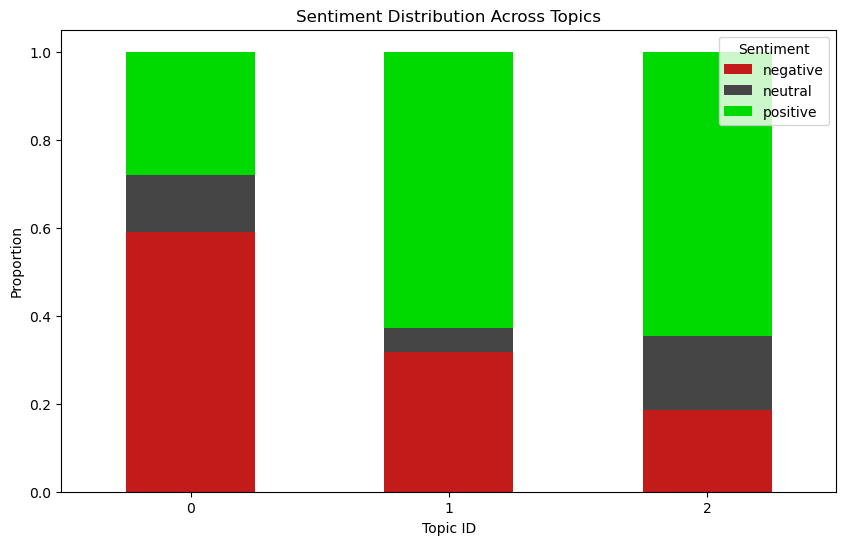

In [126]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Analyze each document
sentiment_results = []
for doc in processed_texts:
    scores = sid.polarity_scores(doc)
    sentiment_results.append({
        'text': doc,
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu'],
        'compound': scores['compound']
    })

# Convert to DataFrame
df_sentiment = pd.DataFrame(sentiment_results)


def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'


df_sentiment['sentiment'] = df_sentiment['compound'].apply(classify_sentiment)

df_sentiment[["text", "sentiment"]].to_csv('../data/labeled_tweets.csv', index=False)  # Extract dataframe to data dir

# Get dominant topic for each document
doc_topics = lda.transform(dt_matrix)
df_sentiment['dominant_topic'] = doc_topics.argmax(axis=1)

# Group by topic and analyze sentiment distribution
topic_sentiment = df_sentiment.groupby('dominant_topic')['sentiment'].value_counts(normalize=True).unstack()
topic_sentiment = topic_sentiment.fillna(0)

# Add topic keywords
topic_keywords = {
    0: " ".join([tf_feature_names[i] for i in lda.components_[0].argsort()[-5:][::-1]]),
    1: " ".join([tf_feature_names[i] for i in lda.components_[1].argsort()[-5:][::-1]]),
    2: " ".join([tf_feature_names[i] for i in lda.components_[2].argsort()[-5:][::-1]])
}
topic_sentiment['keywords'] = topic_sentiment.index.map(topic_keywords)

print(topic_sentiment[['keywords', 'negative', 'neutral', 'positive']])

topic_sentiment[['negative', 'neutral', 'positive']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=["#c31a1a", "#454545", "#00da00"]
)
plt.title("Sentiment Distribution Across Topics")
plt.xlabel("Topic ID")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()

## Naive Bayes model
Train and evaluate a Naive Bayes classification model from the generated labeled dataset

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X = df_sentiment['text']  # tweets
y = df_sentiment['sentiment']  # labels

# First split: 10% for final validation, 90% for train/test
X_temp, X_val, y_temp, y_val = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

# Second split: 80% training, 20% testing (of the remaining 90%)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    random_state=42,
    stratify=y_temp
)

# TF-IDF Vectorizer with n-grams
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit ONLY on training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train classifier
nb_clf = MultinomialNB(alpha=0.1)
nb_clf.fit(X_train_tfidf, y_train)

# Evaluate on test set
y_pred_test = nb_clf.predict(X_test_tfidf)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_test))



Test Set Performance:
              precision    recall  f1-score   support

    negative       0.71      0.71      0.71        34
     neutral       1.00      0.17      0.29        12
    positive       0.77      0.92      0.84        52

    accuracy                           0.76        98
   macro avg       0.83      0.60      0.61        98
weighted avg       0.78      0.76      0.73        98



## Rule-based Model
Train and evaluate a Rule-based classification model from the generated labeled dataset

In [128]:
# Generate lexicons using TF-IDF
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

def generate_ngram_lexicons(df, min_freq, tfidf_threshold, top_n, text_column='text', sentiment_column='sentiment'):
    # Initialize containers
    unigram_lexicons = defaultdict(set)
    bigram_lexicons = defaultdict(set)

    # Create class documents
    classes = df[sentiment_column].unique()
    class_docs = {c: ' '.join(df[df[sentiment_column] == c][text_column]) for c in classes}

    # Generate unigrams with TF-IDF
    uni_vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=min_freq)
    uni_matrix = uni_vectorizer.fit_transform(class_docs.values())
    uni_features = uni_vectorizer.get_feature_names_out()

    # Generate bigrams with TF-IDF
    bi_vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=min_freq)
    bi_matrix = bi_vectorizer.fit_transform(class_docs.values())
    bi_features = bi_vectorizer.get_feature_names_out()

    # Process unigrams
    for i, sentiment_class in enumerate(classes):
        scores = uni_matrix[i].toarray()[0]
        top_indices = np.argsort(scores)[::-1][:top_n]
        for idx in top_indices:
            if scores[idx] > tfidf_threshold:
                unigram_lexicons[sentiment_class].add(uni_features[idx])

    # Process bigrams
    for i, sentiment_class in enumerate(classes):
        scores = bi_matrix[i].toarray()[0]
        top_indices = np.argsort(scores)[::-1][:top_n]
        for idx in top_indices:
            if scores[idx] > tfidf_threshold:
                bigram_lexicons[sentiment_class].add(bi_features[idx])

    # Remove ambiguous n-grams
    for lexicon in [unigram_lexicons, bigram_lexicons]:
        all_ngrams = []
        for words in lexicon.values():
            all_ngrams.extend(list(words))
        ngram_counts = pd.Series(all_ngrams).value_counts()
        ambiguous = set(ngram_counts[ngram_counts > 1].index)

        for sentiment_class in classes:
            lexicon[sentiment_class] = lexicon[sentiment_class] - ambiguous

    return dict(unigram_lexicons), dict(bigram_lexicons)

# Split data
# 80% training, 20% testing (of the remaining 90% from earlier)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    random_state=42,
    stratify=y_temp
)
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Generate lexicons
uni_lex, bi_lex = generate_ngram_lexicons(train_df, min_freq=2, tfidf_threshold=0.08, top_n=50)

# Display words
print("UNIGRAM LEXICONS:")
for sentiment, words in uni_lex.items():
    print(f"\n{sentiment.upper()} words ({len(words)}):")
    print(list(words))
print("\n\nBIGRAM LEXICONS:")
for sentiment, phrases in bi_lex.items():
    print(f"\n{sentiment.upper()} phrases ({len(phrases)}):")
    print(list(phrases))

UNIGRAM LEXICONS:

POSITIVE words (7):
['solution', 'support', 'future', 'sustainability', 'reduce', 'warming', 'like']

NEUTRAL words (9):
['weather', 'planet', 'sea', 'level', 'price', 'heminetwork', 'rising', 'understand', 'selling']

NEGATIVE words (3):
['time', 'need', 'crisis']


BIGRAM LEXICONS:

POSITIVE phrases (1):
['reduce carbon']

NEUTRAL phrases (3):
['selling climate', 'impact climate', 'rising sea']

NEGATIVE phrases (3):
['due climate', 'climate emergency', 'greenhouse gas']


### Classification Rules
Define and apply classification rules

In [129]:
# Separate words
positive_words = lexicons.get('positive', set())
negative_words = lexicons.get('negative', set())
neutral_words = lexicons.get('neutral', set())

# Separate bigrams
positive_phrases = list(bi_lex.get('positive', []))
negative_phrases = list(bi_lex.get('negative', []))
neutral_phrases = list(bi_lex.get('neutral', []))


def classify(text):
    words = text.split()

    # Check bigrams
    for phrase in positive_phrases:
        if phrase in text:  # Phrase matching
            return 'positive'
    for phrase in negative_phrases:
        if phrase in text:
            return 'negative'

    # Check single words
    for phrase in positive_phrases:
        if phrase in text:
            return 'positive'
    for phrase in negative_phrases:
        if phrase in text:
            return 'negative'

    # Count sentiment words
    pos_count = sum(1 for word in words if word in uni_lex.get('positive', []))
    neg_count = sum(1 for word in words if word in uni_lex.get('negative', []))

    # Neutral context override
    if any(word in neutral_words for word in words):
        if pos_count - neg_count >= 3:  # Strong positive bias needed
            return 'positive'
        elif neg_count - pos_count >= 3:  # Strong negative bias needed
            return 'negative'
        else:
            return 'neutral'

    # Score
    sentiment_score = pos_count - neg_count
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

### Evaluate Workflow
Compare to truth labels.

In [130]:
from sklearn.metrics import accuracy_score, f1_score

test_df['predicted'] = test_df["text"].apply(classify)

# Classification report
print("Detailed Classification Report:")
print(classification_report(test_df['sentiment'], test_df['predicted'], digits=4))

# Overall accuracy
accuracy = accuracy_score(test_df['sentiment'], test_df['predicted'])
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Weighted F1-score
weighted_f1 = f1_score(test_df['sentiment'], test_df['predicted'], average='weighted')
print(f"Weighted F1-Score: {weighted_f1:.4f}")

Detailed Classification Report:
              precision    recall  f1-score   support

    negative     0.8636    0.5588    0.6786        34
     neutral     0.1818    0.6667    0.2857        12
    positive     0.7812    0.4808    0.5952        52

    accuracy                         0.5306        98
   macro avg     0.6089    0.5688    0.5198        98
weighted avg     0.7364    0.5306    0.5862        98


Overall Accuracy: 0.5306
Weighted F1-Score: 0.5862


## Unseen Data Testing
Compare the performance of the Naive Bayes and Rule-based classifiers.

In [131]:
# Naive-Bayes
print("NAIVE BAYES CLASSIFICATION RESULTS:")
X_val_tfidf = tfidf.transform(X_val)
val_result = nb_clf.predict(X_val_tfidf)
print("Detailed Classification Report:")
print(classification_report(y_val, val_result))

# Overall accuracy
accuracy = accuracy_score(y_val, val_result)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Weighted F1-score
weighted_f1 = f1_score(y_val, val_result, average='weighted')
print(f"Weighted F1-Score: {weighted_f1:.4f}")

print("-------------------------------------------------------------")

# Rule-based
print("\nRULE-BASED CLASSIFICATION RESULTS:")
val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
val_df['predicted'] = val_df["text"].apply(classify)

# Classification report
print("Detailed Classification Report:")
print(classification_report(test_df['sentiment'], test_df['predicted'], digits=4))

# Overall accuracy
accuracy = accuracy_score(test_df['sentiment'], test_df['predicted'])
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Weighted F1-score
weighted_f1 = f1_score(test_df['sentiment'], test_df['predicted'], average='weighted')
print(f"Weighted F1-Score: {weighted_f1:.4f}")

NAIVE BAYES CLASSIFICATION RESULTS:
Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72        18
     neutral       0.60      0.43      0.50         7
    positive       0.81      0.86      0.83        29

    accuracy                           0.76        54
   macro avg       0.71      0.67      0.69        54
weighted avg       0.75      0.76      0.75        54


Overall Accuracy: 0.7593
Weighted F1-Score: 0.7531
-------------------------------------------------------------

RULE-BASED CLASSIFICATION RESULTS:
Detailed Classification Report:
              precision    recall  f1-score   support

    negative     0.8636    0.5588    0.6786        34
     neutral     0.1818    0.6667    0.2857        12
    positive     0.7812    0.4808    0.5952        52

    accuracy                         0.5306        98
   macro avg     0.6089    0.5688    0.5198        98
weighted avg     0.7364    0.5306    0.5862